Dicoding IDCamp 2024: Machine Learning Terapan

Predictive Analytics

Nama: Nugroho Adi Wirapratama

Email: adiwira009@gmail.com

LinkedIn: https://www.linkedin.com/in/nug-adiwira/

Github: https://github.com/adiwira09

Untuk mempercepat pengambilan data harga saham BBRI di Yahoo Finance, saya menggunakan extension **Chrome: Data Scraper**. Kemudian saya export ke dalam bentuk .csv

# Import library

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from keras_tuner import RandomSearch

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from pandas.plotting import autocorrelation_plot, lag_plot

# Load data

In [ ]:
df = pd.read_csv('finance.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,"Dec 30, 2024","4,080.00","4,120.00","4,070.00","4,080.00","153,934,700"
1,"Dec 27, 2024",135.00,NaN,NaN,NaN,NaN
2,"Dec 27, 2024","4,100.00","4,120.00","4,080.00","4,100.00","143,104,400"
3,"Dec 24, 2024","4,220.00","4,250.00","4,170.00","4,200.00","199,536,100"
4,"Dec 23, 2024","4,130.00","4,210.00","4,110.00","4,210.00","167,689,800"


- Date : Tanggal perdagangan saham yang tercatat, yaitu hari di mana transaksi saham dilakukan di pasar.
Open : Harga pertama yang tercatat pada saat pasar dibuka pada hari tersebut.
- High : Harga tertinggi yang tercatat selama sesi perdagangan pada hari itu.
- Low : Harga terendah yang tercatat selama sesi perdagangan pada hari itu.
- Closing : Harga saham pada saat pasar ditutup pada akhir sesi perdagangan.
- Volume : Jumlah total saham yang diperdagangkan pada hari tersebut.

# Data Understanding

In [ ]:
baris, kolom = df.shape
print(f'Jumlah baris: {baris}')
print(f'Jumlah kolom: {kolom}')

Jumlah baris: 728
Jumlah kolom: 6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    728 non-null    object
 1   Open    728 non-null    object
 2   High    722 non-null    object
 3   Low     722 non-null    object
 4   Close   722 non-null    object
 5   Volume  722 non-null    object
dtypes: object(6)
memory usage: 34.3+ KB


Semua tipe data kolom pada dataset belum sesuai, masih berupa object/string.

In [ ]:
# Mengonversi kolom 'Date' menjadi datetime
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')

# Mengonversi kolom 'Open', 'High', 'Low', 'Close', 'Volume' menjadi numerik
df['Open'] = df['Open'].replace({',': ''}, regex=True).astype(float)
df['High'] = df['High'].replace({',': ''}, regex=True).astype(float)
df['Low'] = df['Low'].replace({',': ''}, regex=True).astype(float)
df['Close'] = df['Close'].replace({',': ''}, regex=True).astype(float)
df['Volume'] = df['Volume'].replace({',': ''}, regex=True).astype(float)

## Cek NaN value

In [ ]:
df.isnull().sum()

,0
Date,0
Open,0
High,6
Low,6
Close,6
Volume,6


Dataset memiliki null value pada kolom Low, Close, dan Volume sebanyak 6 baris

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2024-12-30,4080.0,4120.0,4070.0,4080.0,153934700.0
1,2024-12-27,135.0,NaN,NaN,NaN,NaN
2,2024-12-27,4100.0,4120.0,4080.0,4100.0,143104400.0
3,2024-12-24,4220.0,4250.0,4170.0,4200.0,199536100.0
4,2024-12-23,4130.0,4210.0,4110.0,4210.0,167689800.0


In [ ]:
# Melihat data NaN
df[df.isna().any(axis=1)]

,Date,Open,High,Low,Close,Volume
1,2024-12-27,135.00,NaN,NaN,NaN,NaN
190,2024-03-14,235.00,NaN,NaN,NaN,NaN
238,2024-01-02,84.00,NaN,NaN,NaN,NaN
422,2023-03-24,231.22,NaN,NaN,NaN,NaN
473,2023-01-10,57.00,NaN,NaN,NaN,NaN
680,2022-03-11,174.25,NaN,NaN,NaN,NaN


Terlihat bahwa value hanya terisi pada kolom Open. Jika kita lihat pada kolom lainnya, value dari Open pun tidak berada di rentang **puluhan/ratusan**.

Setelah meihat kembali pada data, NaN value tersebut adalah **besaran nilai dividen yang dibagikan oleh perusahaan kepada investor** pada hari itu.

Oleh karena itu baris tersebut di drop/hapus.

In [ ]:
df_clean = df.dropna()

In [ ]:
df_clean.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


## Cek duplikat

In [ ]:
print(f'Jumlah data duplikat: {df.duplicated().sum()}')

Jumlah data duplikat: 0


Dataset tidak memiliki duplikat data.

## EDA

### Closing Price Trend

In [ ]:
# Set kolom Date sebagai index
df_clean.set_index('Date', inplace=True)

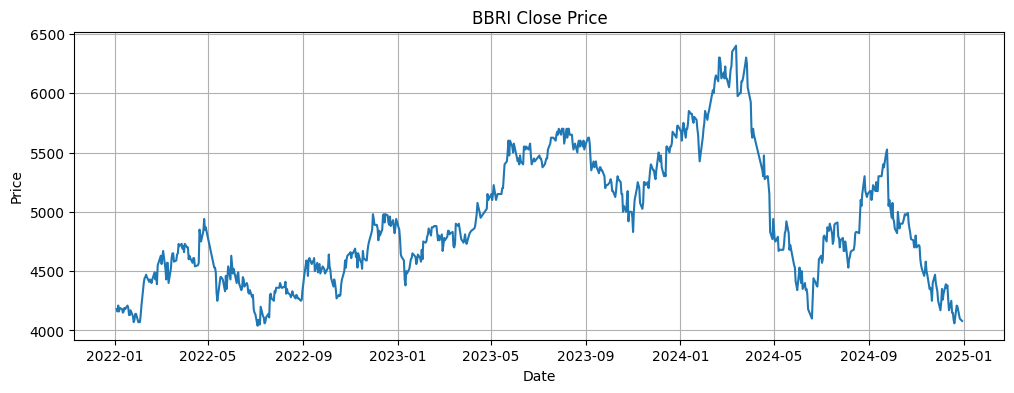

In [ ]:
# 1. Plot harga penutupan
plt.figure(figsize=(12,4))
plt.plot(df_clean['Close'])
plt.title('BBRI Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Grafik ini memperlihatkan fluktuasi harga saham BBRI dari awal 2022 hingga awal 2025. Secara keseluruhan, ada tren kenaikan yang signifikan dari 2022 ke 2023, dengan beberapa fluktuasi tajam. Kemudian, harga saham mulai turun secara drastis setelah 2024.

Harga saham BBRI mengalami kenaikan yang tajam di beberapa titik, namun diikuti dengan penurunan yang signifikan, terutama di 2024 dan 2025. Ada beberapa lonjakan harga yang sangat tinggi di beberapa bulan.

<ipython-input-42-bb2f7152e57b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['MA30'] = df_clean['Close'].rolling(window=30).mean()


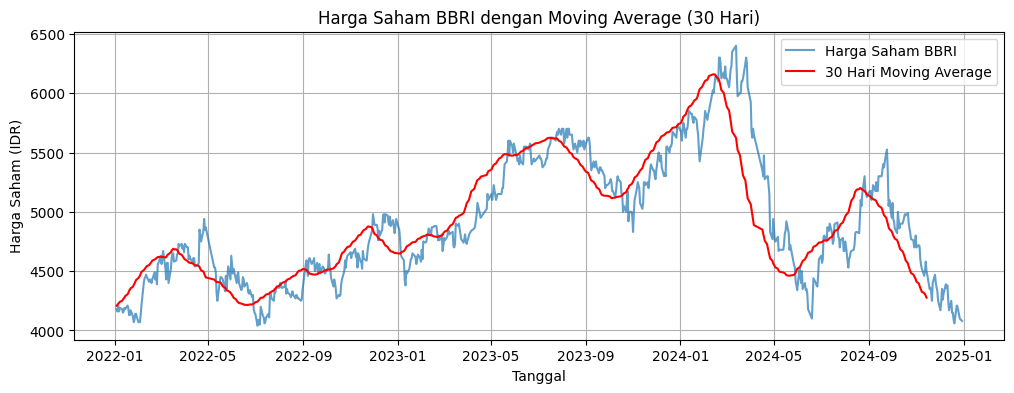

In [ ]:
# Menghitung moving average 30 hari (bisa disesuaikan)
df_clean['MA30'] = df_clean['Close'].rolling(window=30).mean()

# Visualisasi harga saham dengan moving average
plt.figure(figsize=(12, 4))
plt.plot(df_clean['Close'], label='Harga Saham BBRI', alpha=0.7)
plt.plot(df_clean['MA30'], label='30 Hari Moving Average', color='red', linestyle='-')
plt.title('Harga Saham BBRI dengan Moving Average (30 Hari)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham (IDR)')
plt.grid(True)
plt.legend()
plt.show()

Moving average 30 hari memberikan gambaran bahwa harga saham BBRI cenderung naik dengan lonjakan-lonjakan signifikan, meskipun ada periode penurunan yang cukup tajam. Moving average ini membantu menghaluskan fluktuasi harian dan memperlihatkan tren jangka panjang yang lebih stabil.

### Rata-rata closing price per bulan

<ipython-input-47-5bd03268be74>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df_clean.resample('M').mean()


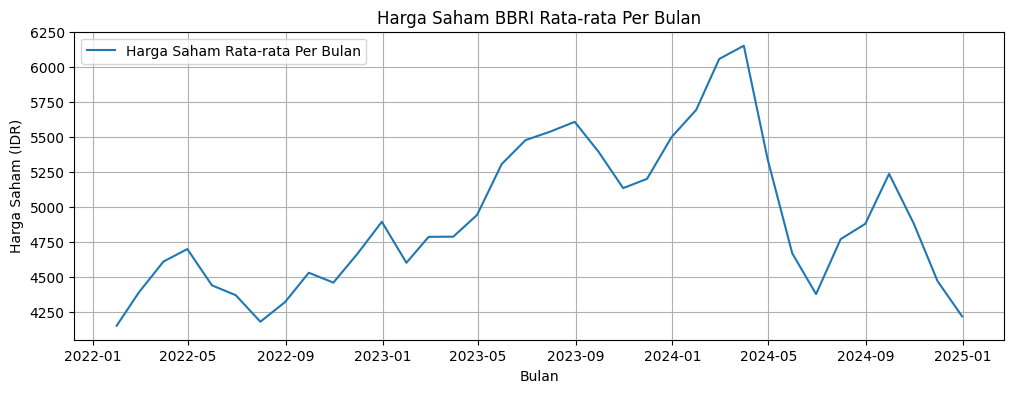

In [ ]:
# Mengelompokkan data berdasarkan bulan dan menghitung rata-rata harga saham per bulan
monthly_data = df_clean.resample('M').mean()

# Visualisasi harga saham rata-rata per bulan
plt.figure(figsize=(12, 4))
plt.plot(monthly_data.index, monthly_data['Close'], label='Harga Saham Rata-rata Per Bulan')
plt.title('Harga Saham BBRI Rata-rata Per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Harga Saham (IDR)')
plt.grid(True)
plt.legend()
plt.show()

Ada beberapa bulan dengan harga yang lebih tinggi, dan ada beberapa bulan yang harga sahamnya lebih rendah. Hal ini bisa menunjukkan adanya pola musiman atau faktor-faktor eksternal yang mempengaruhi harga saham pada waktu-waktu tertentu.

### Closing price trend by Year

In [ ]:
df_yearly = df_clean[['Close']].copy()
df_yearly['Year'] = df_yearly.index.year

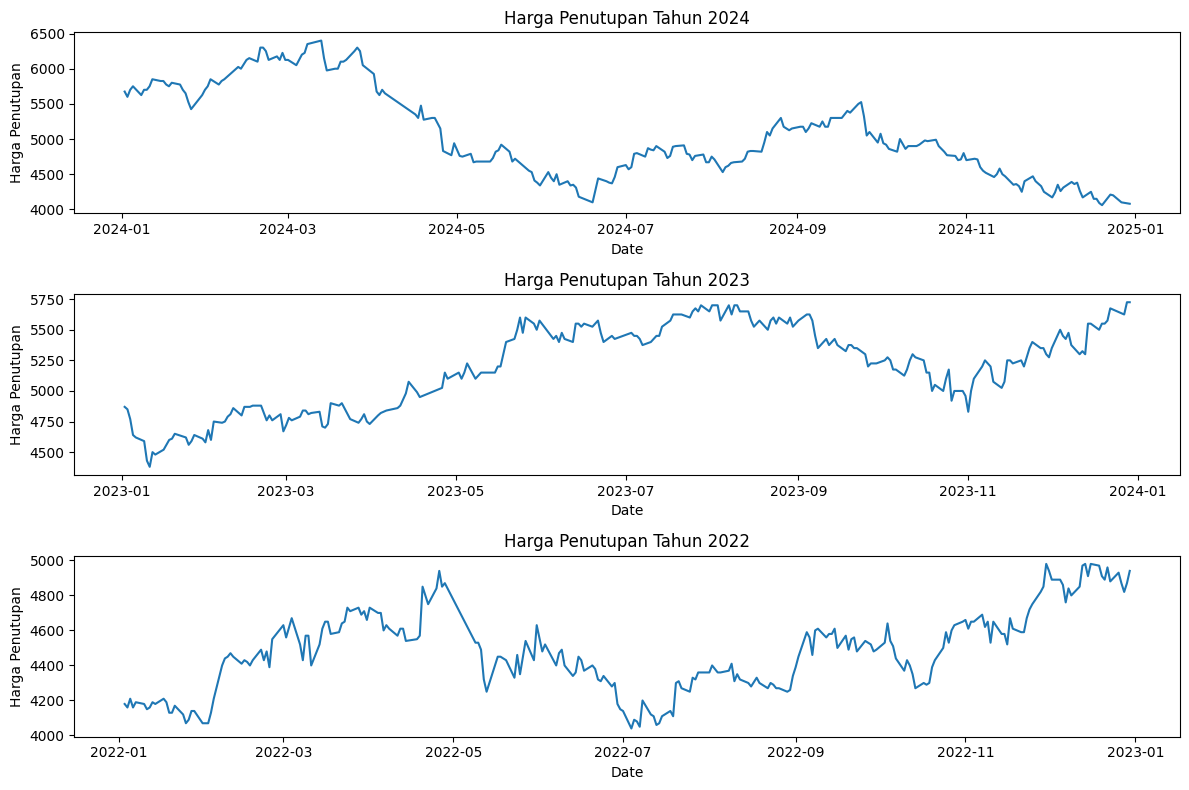

In [ ]:
# Membuat plot untuk setiap tahun
plt.figure(figsize=(12, 8))

years = df_yearly['Year'].unique()
for i, year in enumerate(years, 1):
    plt.subplot(len(years), 1, i)
    yearly_data = df_yearly[df_yearly['Year'] == year]
    plt.plot(yearly_data['Close'], linestyle='-')
    plt.title(f'Harga Penutupan Tahun {year}')
    plt.xlabel('Date')
    plt.ylabel('Harga Penutupan')

plt.tight_layout()
plt.show()

Harga penutupan BBRI cenderung akan naik di awal tahun sampai pertengahan tahun, dan akan kembali naik mendekati akhir tahun.

Tahun 2024 agar berbeda dikarenakan adanya keresahan investor mengenai isu politik dengan pemilihan presiden baru.

### Distribusi Closing Price

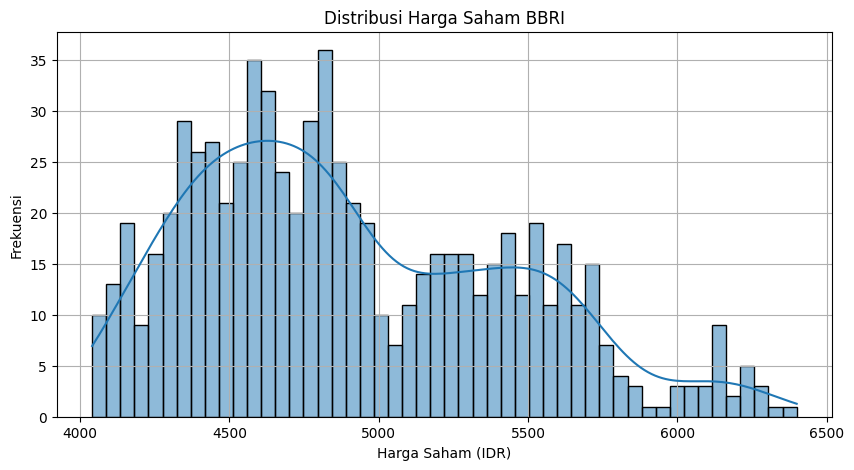

In [ ]:
# Visualisasi distribusi harga saham BBRI dengan histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Close'], bins=50, kde=True)  # KDE (Kernel Density Estimation) untuk memperlihatkan distribusi
plt.title('Distribusi Harga Saham BBRI')
plt.xlabel('Harga Saham (IDR)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

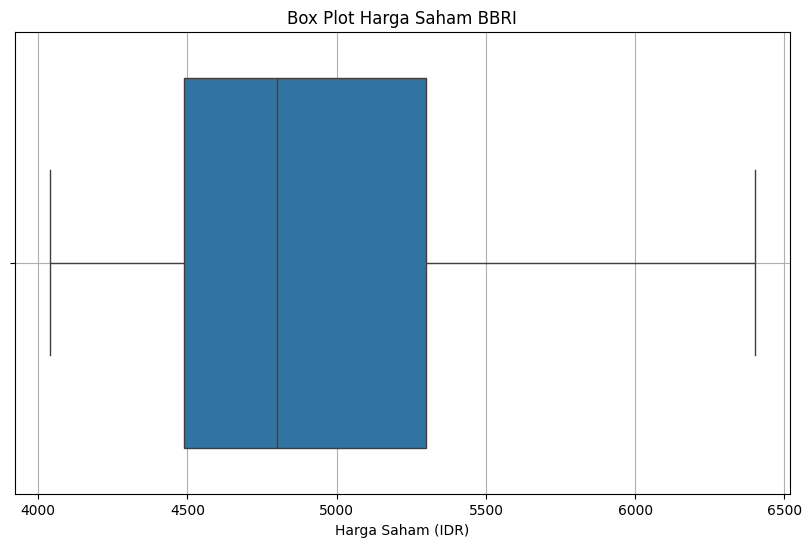

In [ ]:
# Visualisasi distribusi harga saham BBRI dengan box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['Close'])
plt.title('Box Plot Harga Saham BBRI')
plt.xlabel('Harga Saham (IDR)')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import skew, kurtosis

# Menghitung skewness dan kurtosis dari harga saham
skewness = skew(df_clean['Close'])
kurt = kurtosis(df_clean['Close'])

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

Skewness: 0.5798463401031629
Kurtosis: -0.4310046743462572


- **Distribusi Tidak Normal**
- **Skewness Positif**



### Return harian

<ipython-input-54-c64d25ddb03e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Daily Return'] = df_clean['Close'].pct_change() * 100


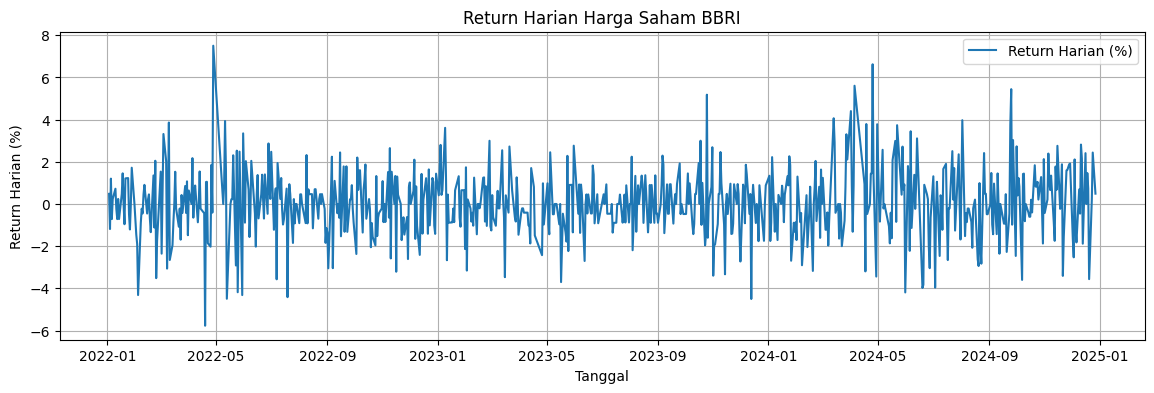

In [ ]:
# Visualisasi return harian
df_clean['Daily Return'] = df_clean['Close'].pct_change() * 100

plt.figure(figsize=(14, 4))
plt.plot(df_clean['Daily Return'], label='Return Harian (%)')
plt.title('Return Harian Harga Saham BBRI')
plt.xlabel('Tanggal')
plt.ylabel('Return Harian (%)')
plt.grid(True)
plt.legend()
plt.show()

Grafik menunjukkan fluktuasi harian yang cukup besar, dengan banyak lonjakan tajam baik ke atas maupun ke bawah. Beberapa puncak tajam menunjukkan periode dengan perubahan harga yang sangat besar dalam waktu singkat. Ini mengindikasikan bahwa harga saham BBRI mengalami volatilitas yang cukup tinggi di banyak titik waktu.

In [ ]:
volatilitas = df_clean['Daily Return'].std()
print(f"Volatilitas harian (standar deviasi): {volatilitas}")

Volatilitas harian (standar deviasi): 1.615190518090041


**1.615%** menunjukkan bahwa perubahan harga saham BBRI per hari cenderung cukup besar dalam konteks volatilitas. Ini berarti harga saham BBRI dapat bergerak naik atau turun lebih dari 1.6% dalam satu hari secara rata-rata.

# Data Preparation

## Normalisasi

In [ ]:
# Menggunakan MinMaxScaler untuk normalisasi data harga saham
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_clean[['Close']])

## Time-step & Split dataset

In [ ]:
# Menentukan jumlah time steps (lag)
time_step = 5

# Membagi data menjadi training dan testing set
train_size = int(len(df_clean) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
# Membuat dataset dengan time_step untuk training dan testing
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshaping data untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Menampilkan dimensi data
X_train.shape, X_test.shape

((571, 5, 1), (139, 5, 1))

# Model Development

## Tuning

In [ ]:
def build_model(hp):
    model = Sequential()

    # Mengatur jumlah unit LSTM secara dinamis
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))  # Regularisasi dropout

    # Menambahkan lapisan LSTM kedua
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Lapisan output
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

In [ ]:
tuner = RandomSearch(build_model,
                     objective='val_loss',
                     max_trials=5,  # Menentukan berapa banyak kombinasi yang akan dicoba
                     executions_per_trial=1,  # Jumlah percobaan untuk setiap kombinasi
                     directory='my_dir',
                     project_name='lstm_tuning')

tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 19s]
val_loss: 0.001984143629670143

Best val_loss So Far: 0.0018892759690061212
Total elapsed time: 00h 01m 25s


In [ ]:
# Menampilkan kombinasi hyperparameter terbaik
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'units': 150, 'dropout': 0.4, 'units_2': 200, 'dropout_2': 0.30000000000000004}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Build model with best parameter

In [ ]:
model = Sequential(name='lstm_forecast')

model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.4))

model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer=Adam(), loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "lstm_forecast"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 150)         │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200)            │       280,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,201 (1.42 MB)

 Trainable params: 372,201 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.1179 - val_loss: 0.0031
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0133 - val_loss: 0.0030
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0054 - val_loss: 0.0022
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0

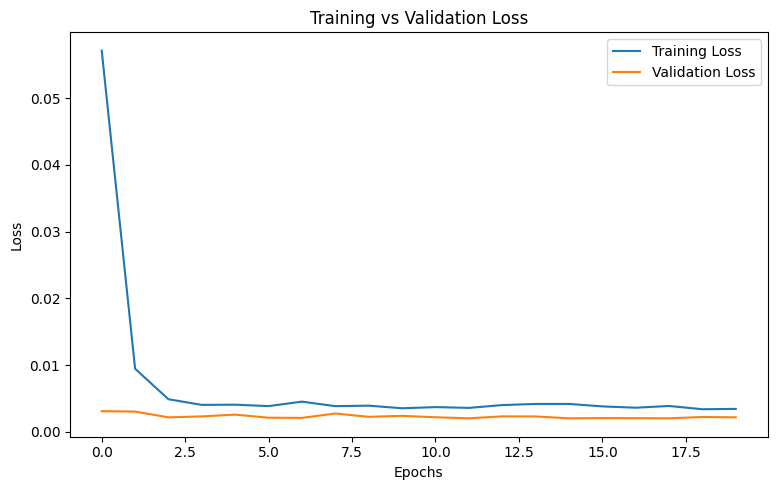

In [ ]:
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss values
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [ ]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape_lstm = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2_lstm = r2_score(y_test_actual, predictions)

print(f'RMSE: {rmse_lstm}')
print(f'MAPE: {mape_lstm}')
print(f'R² Score: {r2_lstm}')

RMSE: 104.48144718920904
MAPE: 1.6403591247308735
R² Score: 0.7595615661462917


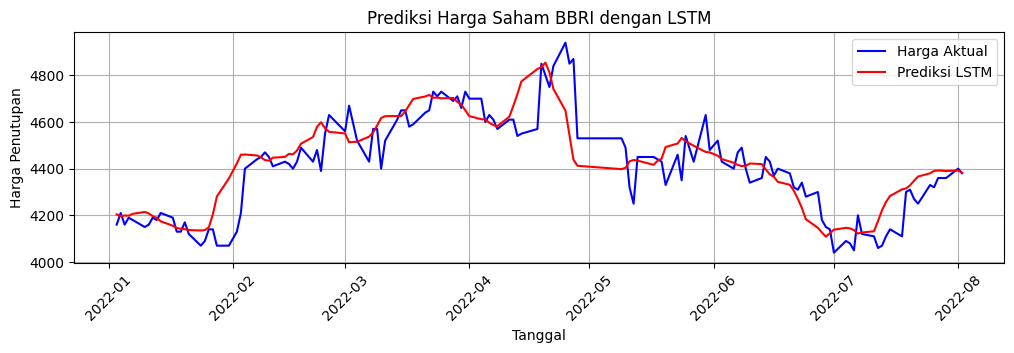

In [ ]:
# Visualisasi hasil prediksi LSTM vs Actual
plt.figure(figsize=(12, 3))
plt.plot(df.index[train_size + time_step + 1:], y_test_actual, label='Harga Aktual', color='blue')
plt.plot(df.index[train_size + time_step + 1:], predictions, label='Prediksi LSTM', color='red')
plt.title('Prediksi Harga Saham BBRI dengan LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()